# Annealing optimizer

The optimizer is used to optimize city blocks of certain land uses by building services of predefined capacity and area.

## Prepare city

The method is time consuming and aimed to work with smaller territories, so we make a smaller model.

In [1]:
from blocksnet import City, AnnealingOptimizer
from blocksnet import AccessibilityProcessor

city = City.from_pickle('model.pickle')



In [2]:
ap = AccessibilityProcessor(blocks=city.get_blocks_gdf())
intermodal_graph = ap.get_intermodal_graph()

Calculating the weights of the walk graph:   0%|          | 0/1170638 [00:00<?, ?it/s]

In [ ]:
ap.plot(blocks, intermodal_graph)

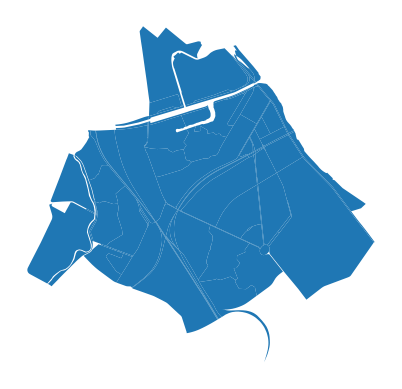

In [3]:
blocks = city.get_blocks_gdf(True)
nearest_blocks = blocks.sjoin_nearest(blocks[blocks.index == 1445], distance_col='distance')
nearest_blocks = nearest_blocks[nearest_blocks['distance']<=1000]
nearest_blocks.plot().set_axis_off()



blocks = gpd.read_parquet(os.path.join(example_data_path, 'blocks.parquet')).to_crs(local_crs)
intermodal_graph = GraphGenerator(territory=blocks).get_graph('intermodal')

In [4]:
city._blocks = {i:city[i] for i in nearest_blocks.index}

## Method

In [5]:
import random
from blocksnet import LandUse
from blocksnet.method.annealing_optimizer import LU_FSIS, LU_GSIS

ao = AnnealingOptimizer(city_model=city)
blocks_lu = {block.id : random.choice(list(LandUse)) for block in city.blocks}
blocks_fsi = {b_id : LU_FSIS[lu][0] for b_id, lu in blocks_lu.items()}
blocks_gsi = {b_id : LU_GSIS[lu][0] for b_id, lu in blocks_lu.items()}
service_types = {st.name : 1/len(city.service_types) for st in city.service_types}
X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, service_types, rate=0.95, max_iter=10_000)

Value : 0.002:   0%|          | 19/10000 [00:01<14:41, 11.33it/s]

AttributeError: 'City' object has no attribute 'accessibility_matrix'

Value : 0.002:   0%|          | 19/10000 [00:19<14:41, 11.33it/s]

In [15]:
print('Best objective value:', value)

Best objective value: 0.46475854673870937


In [16]:
{st : round(value,2)  for st,value in provisions.items()}

{'school': 0.68,
 'kindergarten': 0.22,
 'hospital': 1.0,
 'polyclinic': 0.34,
 'pitch': 0.0,
 'swimming_pool': 0.95,
 'stadium': 1.0,
 'theatre': 1.0,
 'museum': 1.0,
 'cinema': 1.0,
 'mall': 0.88,
 'convenience': 0.18,
 'supermarket': 0.5,
 'cemetery': 0.0,
 'religion': 1.0,
 'market': 0.84,
 'bowling_alley': 1.0,
 'university': 1.0,
 'playground': 0.09,
 'pharmacy': 0.79,
 'fuel': 0.5,
 'beach': 0.0,
 'train_building': 1.0,
 'bank': 0.51,
 'lawyer': 0.88,
 'cafe': 0.34,
 'subway_entrance': 0.45,
 'multifunctional_center': 0.03,
 'hairdresser': 0.47,
 'restaurant': 0.69,
 'bar': 0.46,
 'park': 0.0,
 'government': 1.0,
 'recruitment': 1.0,
 'hotel': 1.0,
 'zoo': 0.0,
 'circus': 0.0,
 'post': 0.13,
 'police': 0.0,
 'dog_park': 0.65,
 'hostel': 0.34,
 'bakery': 0.5,
 'parking': 0.02,
 'guest_house': 0.0,
 'reserve': 0.0,
 'sanatorium': 1.0,
 'embankment': 0.0,
 'machine-building_plant': 1.0,
 'brewery': 0.29,
 'woodworking_plant': 1.0,
 'oil_refinery': 0.0,
 'plant_of_building_materials

In [17]:
ao.to_bricks_df(X).head()

,block_id,service_type,is_integrated,area,capacity,count
4,39,polyclinic,False,1400.0,150,1
28,39,parking,False,4750.0,190,1
58,39,market,False,6000.0,8000,1
82,39,school,False,4000.0,300,1
96,39,museum,True,1300.0,1000,1


In [18]:
ao.to_gdf(X, indicators).head()

,population,mall,plant_of_building_materials,polyclinic,playground,post,pier,landfill,kindergarten,animal_shelter,...,greenhouse_complex,reserve,bar,oil_refinery,bakery,multifunctional_center,embankment,hostel,geometry,land_use
block_id,,,,,,,,,,,,,,,,,,,,,
39,1472,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((352493.392 6644174.577, 352480.316 6...",residential
40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((352846.893 6643739.658, 352854.917 6...",transport
41,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((352713.398 6643353.609, 352656.125 6...",business
42,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((352661.968 6643879.720, 352637.303 6...",transport
43,0,0.0,0.0,0.0,0.0,800.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((353921.529 6644728.862, 353829.106 6...",recreation
